### Import 3rd libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics

### Hyper Parameters

In [ ]:
MAX_SENTENCE_LENGTH = 300
vocab_size = 10000
num_oov_buckets = 1000
d_model = 128
N = 1
dk = dq = 32
h = 4
dff = 256
dropout_rate = 0.3

### Download IMDB Review dataset

In [ ]:
import tensorflow_datasets as tfds
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1PODCS/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1PODCS/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete1PODCS/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Prepare Our dataset

#### Preprocess batches
Convert batches to tokens of words

In [ ]:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, 0, MAX_SENTENCE_LENGTH)
  X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
  X_batch = tf.strings.split(X_batch)
  X_batch = X_batch.to_tensor(default_value=b"<pad>",shape=(X_batch.bounding_shape(axis=0),MAX_SENTENCE_LENGTH))
  y_batch = tf.cast(y_batch,'float32')
  return X_batch,y_batch

#### Create a vocabulary for dataset

In [ ]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common(10)

[(b'<pad>', 6160165),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490)]

In [ ]:
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

#### Create Look up table for vocabulary

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic <pad>".split()]))

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   22,    12,    11, 10053,     0]])>

In [ ]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

#### Our Final model

In [ ]:
train_set = datasets["train"].batch(32).map(preprocess,num_parallel_calls=-1)
train_set = train_set.map(encode_words).prefetch(1)

test_set = datasets['test'].batch(252).map(preprocess,num_parallel_calls=-1)
test_set = test_set.map(encode_words).prefetch(1)

In [ ]:
class PositionalEncoding(layers.Layer):
  def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
    super().__init__(dtype=dtype, **kwargs)
    if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
    p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
    pos_emb = np.empty((1, max_steps, max_dims))
    pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
    pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
    self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))

  def call(self, inputs):
    shape = tf.shape(inputs)
    return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [ ]:
seq = table.lookup(tf.constant([b"This movie was faaaaaantastic <pad>".split()]))
seq

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   22,    12,    11, 10053,     0]])>

In [ ]:
def create_padding_mask(seq):
  mask = tf.cast(tf.math.equal(seq,0),'float32')
  return mask[:,tf.newaxis,:]

In [ ]:
test_text = tf.constant(
    [
     b"Hey How Are You <pad>".split(),
     b"I am good <pad> <pad>".split()
    ]
)

test = table.lookup(test_text)
test

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[2436,  422, 2174,  240,    0],
       [   6,  145,   40,    0,    0]])>

In [ ]:
mask = create_padding_mask(test)
mask

<tf.Tensor: shape=(2, 1, 5), dtype=float32, numpy=
array([[[0., 0., 0., 0., 1.]],

       [[0., 0., 0., 1., 1.]]], dtype=float32)>

In [ ]:
def scaled_dot_product_attention(q, k, v, mask=None):
  attention_logit = tf.matmul(q,k,transpose_b=True)
  dk = tf.cast(tf.shape(k)[-1],'float32')
  scaled_attention_logit = attention_logit / tf.math.sqrt(dk)

  if mask is not None:
    scaled_attention_logit += mask*(-1e9)

  attention = tf.nn.softmax(scaled_attention_logit,axis=-1)
  output = attention @ v
  return output

In [ ]:
class MultiHeadAttention(layers.Layer):
  def __init__(self,h,dk,dv,**kwds):
    super().__init__(**kwds)
    self.h = h
    self.dv = dv
    self.dk = dk

  def build(self,batch_input_shape):
    d = batch_input_shape[-1]
    self.restore = layers.Dense(d,kernel_initializer='glorot_normal')
    self.Q_denses = [layers.Dense(self.dk,kernel_initializer='glorot_normal') for _ in range(self.h)]
    self.K_denses = [layers.Dense(self.dk,kernel_initializer='glorot_normal') for _ in range(self.h)]
    self.V_denses = [layers.Dense(self.dv,kernel_initializer='glorot_normal') for _ in range(self.h)]
    super().build(batch_input_shape)

  def compute_output_shape(self,batch_input_shape):
    return batch_input_shape

  def call(self,Q,K,V,training=None,mask=None):
    outs = [
            scaled_dot_product_attention(
                q_dense(Q),
                k_dense(K),
                v_dense(V),
                mask=mask
            )
            for q_dense,k_dense,v_dense in zip(self.Q_denses,self.K_denses,self.V_denses)
    ]
    output = tf.concat(outs,axis=-1)
    output = self.restore( output, training=training )
    return output

In [ ]:
X_test = tf.random.normal((32,60,128),dtype='float32')
mha = MultiHeadAttention(3,32,32)
mha(X_test,X_test,X_test).shape

TensorShape([32, 60, 128])

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu',kernel_initializer='he_normal'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model,kernel_initializer='glorot_normal')  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(layers.Layer):
  def __init__(self, h, dk, dv, dff, dropout_rate=0.1, **kwds):
    super().__init__(**kwds)
    self.h = h
    self.dv = dv
    self.dk = dk
    self.dff = dff
    self.dropout_rate = dropout_rate

  def build(self,batch_input_shape):
    self.mha = MultiHeadAttention(h,self.dk,self.dv)
    self.dropout1 = layers.Dropout(self.dropout_rate)
    self.normalization1 = layers.LayerNormalization()

    self.ffn = point_wise_feed_forward_network(batch_input_shape[-1],self.dff)
    self.dropout2 = layers.Dropout(self.dropout_rate)
    self.normalization2 = layers.LayerNormalization()
    super().build(batch_input_shape)

  def compute_output_shape(self,batch_input_shape):
    return batch_input_shape

  def call(self, inputs, training = None, mask = None):
    X = inputs
    X = self.mha(X, X, X, mask = mask)
    X = self.dropout1(X, training=training)
    inputs = self.normalization1(X + inputs)

    X = inputs
    X = self.ffn(X)
    X = self.dropout2(X, training=training)
    X = self.normalization2(X + inputs)

    return X

In [ ]:
class Encoder(layers.Layer):
  def __init__(self,N, h, dk, dv, dff, dropout_rate = 0.1, **kwds):
    super().__init__(**kwds)
    self.N = N
    self.h = h
    self.dk = dk
    self.dv = dv
    self.dropout_rate = dropout_rate
    self.dff = dff

  def build(self,batch_input_shape):
    self.encoder_layers = [
                           EncoderLayer(self.h, self.dk, self.dv, self.dff, self.dropout_rate)
                           for _ in range(N)
    ]
    super().build(batch_input_shape)

  def compute_output_shape(self,batch_input_shape):
      return batch_input_shape

  def call(self,inputs,training = None, mask = None):
    X = inputs
    for layer in self.encoder_layers:
      X = layer(X, training=training, mask=mask)
    
    return X

In [ ]:
class Transformer(models.Model):
  def __init__(self,input_embed_size, d_model, N, h, dk, dq, dff, dropout_rate = 0.1, **kwds):
    super().__init__(**kwds)
    self.N = N
    self.h = h
    self.dk = dk
    self.dq = dq
    self.dropout_rate = dropout_rate
    self.dff = dff
    self.d_model = d_model
    self.input_embed_size = input_embed_size

  def build(self,batch_input_shape):
    self.embedding = layers.Embedding(self.input_embed_size,self.d_model)
    self.positional_encoder = PositionalEncoding(max_steps=300,max_dims=self.d_model)
    self.dropout_layer = layers.Dropout(self.dropout_rate)

    self.encoder = Encoder(self.N, self.h, self.dk, self.dq, self.dff, self.dropout_rate)
    self.flatten = layers.Flatten()
    self.dropout2 = layers.Dropout(self.dropout_rate)
    self.classification_layer = layers.Dense(1,'sigmoid',kernel_initializer='glorot_normal')
    
    super().build(batch_input_shape)

  def compute_output_shape(self,batch_input_shape):
    return np.array([batch_input_shape[0],1])

  def call(self,inputs,training=None):
    mask = create_padding_mask(inputs)
    word_embed = self.embedding(inputs)
    word_embed *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    embed = self.positional_encoder(word_embed)

    X = self.dropout_layer(embed, training=training)
    X = self.encoder(X, training=training, mask=mask)

    X = self.flatten(X)
    X = self.dropout2(X)
    X = self.classification_layer(X)
    return X

In [ ]:
input_embed_size = table.size()
model = Transformer(
    input_embed_size,d_model, N, h, dk, dq, dff, dropout_rate,
)

In [ ]:
for X_batch,y_batch in train_set:break

In [ ]:
model(X_batch)
model.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1408000   
_________________________________________________________________
positional_encoding (Positio multiple                  0         
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
encoder (Encoder)            multiple                  132480    
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_10 (Dense)             multiple                  

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
EPOCHS = 20

optimizer = optimizers.Adam(CustomSchedule(d_model), beta_1=0.9, beta_2=0.98,epsilon=1e-9)
cb = [
      callbacks.EarlyStopping(patience=4,restore_best_weights=True,),
      #callbacks.ReduceLROnPlateau(patience=2,factor=0.5,min_lr=1e-4)
]

model.compile(optimizer,losses.binary_crossentropy,['acc'])

In [ ]:
history = model.fit(train_set,epochs=EPOCHS,validation_data=test_set,callbacks=cb)

Epoch 1/20
782/782 [==============================] - 33s 39ms/step - loss: 0.8912 - acc: 0.5033 - val_loss: 0.5863 - val_acc: 0.6859
Epoch 2/20
782/782 [==============================] - 30s 38ms/step - loss: 0.6990 - acc: 0.6559 - val_loss: 0.4959 - val_acc: 0.7556
Epoch 3/20
782/782 [==============================] - 30s 38ms/step - loss: 0.5355 - acc: 0.7634 - val_loss: 0.5149 - val_acc: 0.7628
Epoch 4/20
782/782 [==============================] - 30s 38ms/step - loss: 0.4479 - acc: 0.8119 - val_loss: 0.5680 - val_acc: 0.7544
Epoch 5/20
782/782 [==============================] - 30s 38ms/step - loss: 0.3698 - acc: 0.8488 - val_loss: 0.5944 - val_acc: 0.7425
Epoch 6/20
782/782 [==============================] - 30s 38ms/step - loss: 0.3279 - acc: 0.8698 - val_loss: 0.8420 - val_acc: 0.7293


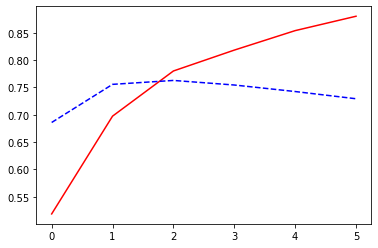

In [ ]:
plt.plot(history.epoch,history.history['acc'],'r-')
plt.plot(history.epoch,history.history['val_acc'],'b--')